# The k-armed bandit testbed#

In this workbook, we setup and use a testbed for the $k$-armed bandit problem where $k=10$.

The $k$-armed bandit problem is defined as a number of $k$ actions that each yield some reward with mean $q_*(a)$ and unit variance. Given a limited number of timesteps in which to select an action and receive a reward, how can an agent quickly find and exploit the most rewarding actions?

In this case, we will specifically be looking at the effect that $\epsilon$ has when employing an $\epsilon$-greedy policy for both a stationary $k$-armed bandit problem as well as a nonstationary one where the values of $q_*(a)$ make small steps in a random direction after every time step.

In [1]:
import numpy as np
from random import normalvariate
from random import choice
from random import random
from random import randint
from matplotlib import pyplot as plt

To set up our k-armed bandit problem where $k=10$ we draw 10 values from the normal distribution to represent the true values ($q_*(a)$) of each of our bandits

In [8]:
class bandit_problem:
    
    def __init__(self, k):
        self.k = k
        self.q_a = np.random.standard_normal(self.k)
    
    def get_reward(self, action):
        return normalvariate(self.q_a[action], 1)
    
    def reset(self):
        self.q_a = np.random.standard_normal(self.k)

Then, in order to calculate the reward for selecting an action (in this case $a=0$) we sample from the normal distribution again, but with mean $q_*(a)$ and unit variance.

Now for our agent that will be choosing and triggering the actions in order to obtain the reward. Essentially, we would like it to be greedy but with the catch that there is a probability of $\epsilon$ to choose an action randomly it goes on to look something like this:

In [9]:
class bandit_agent:
   
    def __init__(self, epsilon, k):
        self.Q_a = np.zeros(k)
        self.N_a = np.zeros(k)
        self.epsilon = epsilon
        self.k = k
    
    def choose_action(self):
        if (random() < self.epsilon):
            action = randint(0,self.k-1)
        else:
            max_actions = np.where(self.Q_a == np.amax(self.Q_a))
            action = choice(max_actions[0])
        self.N_a[action] += 1
        return action
    
    def update(self, action, reward):
        self.Q_a[action] += (reward - self.Q_a[action])/self.N_a[action]
    
    def reset(self):
        self.Q_a = np.zeros(k)
        self.N_a = np.zeros(k)

In this agent's `update` method we use the _sample-average_ method to calculate the action-values incrementally. The sample-average method works by taking the prior action-value $Q(A_{t-1})$ and updating it with the latest reward recieved $R_t$ for choosing the current action $A_t$ discounted by the number of times that the current action has been selected in the past $N(A_t)$. 

The idea is to update the average reward recieved each time we selected a specific average, hence sample-average. Which brings us to the following equation:

$$Q_{t+1}(A) = Q_t + \frac{1}{N}[R_t(A_t) - Q_t(A_t)]$$

In [60]:
def run_simulation(num_steps, num_runs, k, epsilon):

    rewards = np.zeros((num_runs, num_steps))

    problem = bandit_problem(k)
    agent = bandit_agent(epsilon, k)

    for r in range(num_runs):
    
        agent.reset()
    
        for t in range(num_steps):
            action = agent.choose_action()
            reward = problem.get_reward(action)
            rewards[r,t] = reward
            agent.update(action, reward)
    
    return rewards

In [61]:
num_steps = 1000
num_runs = 2000
k = 10

In [62]:
e0_rewards = run_simulation(num_steps, num_runs, k, 0)
e01_rewards = run_simulation(num_steps, num_runs, k, 0.1)
e001_rewards = run_simulation(num_steps, num_runs, k, 0.01)

In [63]:
e0_avg_rewards = np.mean(e0_rewards, axis = 0)
e01_avg_rewards = np.mean(e01_rewards, axis = 0)
e001_avg_rewards = np.mean(e001_rewards, axis = 0)

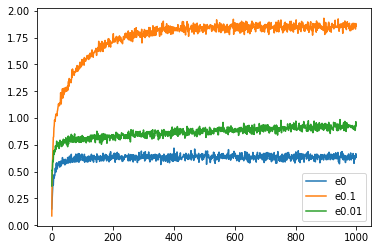

In [64]:
x = np.arange(0, num_steps, 1)

plt.plot(x, e0_avg_rewards, label='e0')
plt.plot(x, e01_avg_rewards, label='e0.1')
plt.plot(x, e001_avg_rewards, label='e0.01')
plt.legend()

## Non-stationary problems ##

Now we look at a version of the k-armed bandit that is non-stationary meaning that at each time step we will be adding a normally distributed increment with mean 0 and standard deviation 0.01 to the values of $q_*(a)$.

In [2]:
class nonstationary_bandit_problem:
    
    def __init__(self, k):
        self.k = k
        self.q_a = np.random.standard_normal(self.k)
    
    def get_reward(self, action):
        return normalvariate(self.q_a[action], 1)
    
    def reset(self):
        self.q_a = np.random.standard_normal(self.k)
    
    def update(self):
        for i in range(self.k):
            self.q_a[i] += normalvariate(0, 0.01)

In [11]:
def run_nonstationary_simulation(num_steps, num_runs, k, epsilon):

    rewards = np.zeros((num_runs, num_steps))

    problem = nonstationary_bandit_problem(k)
    agent = bandit_agent(epsilon, k)

    for r in range(num_runs):
    
        agent.reset()
    
        for t in range(num_steps):
            action = agent.choose_action()
            reward = problem.get_reward(action)
            rewards[r,t] = reward
            agent.update(action, reward)
            problem.update()
    
    return rewards

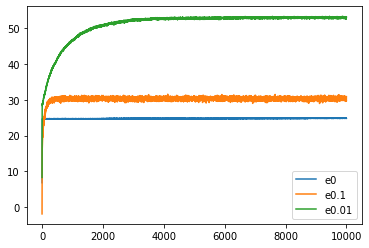

In [15]:
num_steps = 10000
num_runs = 2000
k = 10

e0_rewards = run_nonstationary_simulation(num_steps, num_runs, k, 0)
e01_rewards = run_nonstationary_simulation(num_steps, num_runs, k, 0.1)
e001_rewards = run_nonstationary_simulation(num_steps, num_runs, k, 0.01)

e0_avg_rewards = np.mean(e0_rewards, axis = 0)
e01_avg_rewards = np.mean(e01_rewards, axis = 0)
e001_avg_rewards = np.mean(e001_rewards, axis = 0)

x = np.arange(0, num_steps, 1)

plt.plot(x, e0_avg_rewards, label='e0')
plt.plot(x, e01_avg_rewards, label='e0.1')
plt.plot(x, e001_avg_rewards, label='e0.01')
plt.legend()

### Using a fixed step-size parameter ###

In the sample-average method discussed above, the step-size parameter (denoted as $\alpha$) is $\frac{1}{n}$ where $n$ is the number of times that specific action has been selected in the past. 

Using $\frac{1}{n}$ as the step-size parameter means that as the action is selected more and more over time, the update to the action-value (the term $R - Q_t$) is discounted more strongly for future rewards than past ones.

This can be seen that by the Law of Large numbers as the number of times a specific action is chosen ($n$) tends to infinity it will eventually discount the updates entirely and stop updating the action-values:
$$\lim_{n\to\infty}\frac{1}{n} = 0$$

This is an example of convergence for a RL algorithm. Given enough time, the algorithm will eventually become fixed when it has calculated the optimal action-values. In the case, of the stationary problem above, this is indeed what we want since we would like the agent to eventually exploit the most valuable action it has found after exploring other options.

However, when the problem is non-stationary, the optimal action-value becomes a moving target and convergence is no longer that beneficial. If the agent becomes fixed over time to exploit a given action greedily, it becomes very difficult to change the action-values if the optimal action changes since the longer the agent has been learning, the smaller the updates are to the action-values (especially of the most exploited action).

In this case it might be beneficial to use a fixed step-size parameter such as $\alpha = 0.1$ which means that future reward updates are equally as important as past reward updates.

In [6]:
class nonstationary_bandit_agent:
   
    def __init__(self, epsilon, k, a):
        self.Q_a = np.zeros(k)
        self.epsilon = epsilon
        self.k = k
        self.a = a
    
    def choose_action(self):
        if (random() < self.epsilon):
            action = randint(0,self.k-1)
        else:
            max_actions = np.where(self.Q_a == np.amax(self.Q_a))
            action = choice(max_actions[0])
        return action
    
    def update(self, action, reward):
        self.Q_a[action] += (reward - self.Q_a[action])/self.a
    
    def reset(self):
        self.Q_a = np.zeros(k)
        self.N_a = np.zeros(k)

In [4]:
def run_nonstationary_simulation(num_steps, num_runs, k, epsilon, a):

    rewards = np.zeros((num_runs, num_steps))

    problem = nonstationary_bandit_problem(k)
    agent = nonstationary_bandit_agent(epsilon, k, a)

    for r in range(num_runs):
    
        agent.reset()
    
        for t in range(num_steps):
            action = agent.choose_action()
            reward = problem.get_reward(action)
            rewards[r,t] = reward
            agent.update(action, reward)
            problem.update()
    
    return rewards

In [5]:
num_steps = 10000
num_runs = 2000
k = 10
a = 0.1

e0_rewards = run_nonstationary_simulation(num_steps, num_runs, k, 0, a)
e01_rewards = run_nonstationary_simulation(num_steps, num_runs, k, 0.1, a)
e001_rewards = run_nonstationary_simulation(num_steps, num_runs, k, 0.01, a)

e0_avg_rewards = np.mean(e0_rewards, axis = 0)
e01_avg_rewards = np.mean(e01_rewards, axis = 0)
e001_avg_rewards = np.mean(e001_rewards, axis = 0)

x = np.arange(0, num_steps, 1)

plt.plot(x, e0_avg_rewards, label='e0')
plt.plot(x, e01_avg_rewards, label='e0.1')
plt.plot(x, e001_avg_rewards, label='e0.01')
plt.legend()

/home/julius/monastery/reinforcement-learning/workbooks/venv/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in double_scalars
/home/julius/monastery/reinforcement-learning/workbooks/venv/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in double_scalars


IndexError: Cannot choose from an empty sequence